This notebook simulates the RL agent over a single run and outputs statistics
- Agent rewards over the steps
- A 2D grid of Agent positions

In [1]:
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')
# tf.test.is_built_with_cuda()
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sandpile import Sandpile, run_sandpile_alone
import random
import time
from rl_agents import Policy
from util import Directions
from torch_util import enum_parameters
from agents import RandomAgent, MaxAgent, SeekSpecificValueAgent, SeekCenterAgent

# Set the seed value all over the place to make this reproducible.
seed_val = 42


# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)


In [2]:
# Run the best model
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


# SET UP POLICY AGENT
N_grid = 10
num_hidden_layers = 4
hidden_dim = 64
input_dim = ((2*N_grid-1)**2) # The number of input variables. 
output_dim = len(Directions) # The number of output variables. 

rl_policy_agent = Policy(
    input_dim=input_dim,
    num_hidden_layers=num_hidden_layers,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    device=device
)
enum_parameters(rl_policy_agent)
rl_policy_agent.to(device)

model_nickname = 'reinforce-agent'

# model_dir = f'/staging_area/{model_nickname}/'
model_dir = ''

checkpoint = torch.load(model_dir+'best_rl_policy_agent.tar')
g = checkpoint['model_state_dict']
score = checkpoint['score']
print(f'Best Score: {score}')
rl_policy_agent.load_state_dict(g)

# Put model in evaluation mode
rl_policy_agent.eval()

# start new sandpile with initial grid
rl_policy_agent.reset()


# initialize regular agents with random positions
random_agent = RandomAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1))
max_agent = MaxAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1))
ssv_agent = SeekSpecificValueAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1),specific_value=1)
center_agent = SeekCenterAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1))


# aggregate agents
agents = [rl_policy_agent, random_agent, center_agent]

MAXIMUM_GRAINS = 4
max_nmoves_per_episode = 1000

t0 = time.time()
random_agent_pos = []
center_agent_pos = []
rl_agent_pos = []

    

# # generate initial grid
initial_grid_N = N_grid * N_grid * 4
# print('Generating initial grid')
initial_grid = run_sandpile_alone(N_grid=N_grid, initial_grid=None, MAXIMUM_GRAINS=MAXIMUM_GRAINS, DROP_SAND=True, MAX_STEPS=initial_grid_N)

sandpile = Sandpile(N_grid=N_grid, initial_grid=initial_grid, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=max_nmoves_per_episode, grain_loc_order=None)

# move agent to random position at beginning of episode
# rl_policy_agent.move_agent_to_point(random.randint(0,N_grid-1), random.randint(0,N_grid-1))

# pos = rl_policy_agent.get_agent_pos()

# 
# sandpile = Sandpile(N_grid=N_grid, initial_grid=initial_grid, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=max_nmoves_per_episode, grain_loc_order=None)
# move agent to random position at beginning of episode
# rl_policy_agent.move_agent_to_point(random.randint(0,N_grid-1), random.randint(0,N_grid-1))

# pos = rl_policy_agent.get_agent_pos()

random_agent_pos = []
center_agent_pos = []
rl_policy_agent_pos = []

i = 0
game_is_running = True
with torch.no_grad():
    while game_is_running:
        # print('Step i: ', i)
        i+=1
        sandpile_grid, agent_rewards, game_is_running = sandpile.step()
        pos = rl_policy_agent.get_agent_pos()
        # print('Agent pos (ij): ', pos[0], pos[1])

        # get action and log prob
        action = rl_policy_agent.action_idx


        random_agent_pos.append([random_agent.x_pos, random_agent.y_pos])
        center_agent_pos.append([center_agent.x_pos, center_agent.y_pos])
        rl_policy_agent_pos.append([rl_policy_agent.x_pos, rl_policy_agent.y_pos])
        

        # input()

t1 = time.time()
t_elapsed = t1 - t0
print('Time to run sim: ', t_elapsed)


Using GPU.
Total Trainable Params: 40133
Best Score: 1812.57
Time to run sim:  4.107034206390381


cumulative random_agent score:  848.0
cumulative center_agent score:  1999.0
cumulative rl_agent score:  1774.0


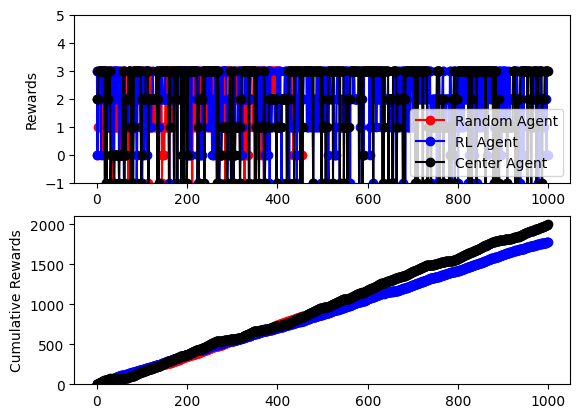

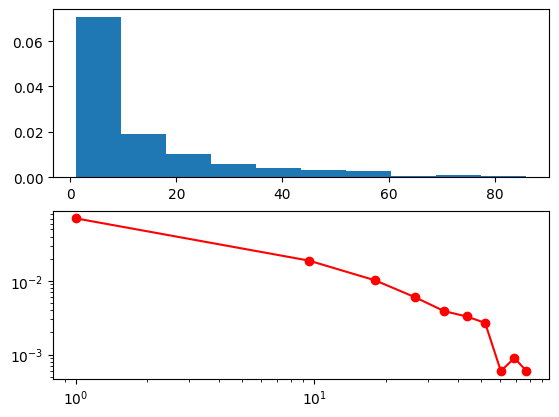

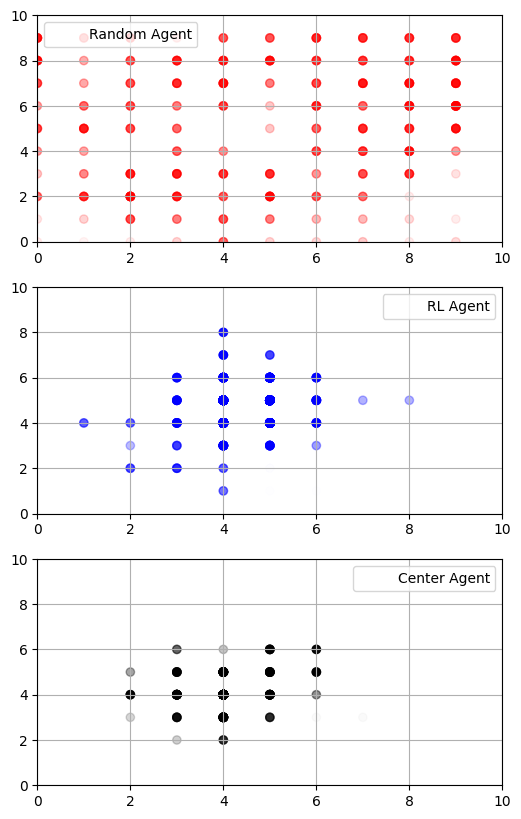

In [3]:
random_agent_pos = np.array(random_agent_pos)
center_agent_pos = np.array(center_agent_pos)
rl_policy_agent_pos= np.array(rl_policy_agent_pos)



print('cumulative random_agent score: ', random_agent.cumulative_score)
print('cumulative center_agent score: ', center_agent.cumulative_score)
print('cumulative rl_agent score: ', rl_policy_agent.cumulative_score)

fig_rewards, axs_rewards = plt.subplots(2,1)
axs_rewards[0].plot(random_agent.rewards,color='r',marker='o',label='Random Agent')
axs_rewards[0].plot(rl_policy_agent.rewards,color='b',marker='o',label='RL Agent')
axs_rewards[0].plot(center_agent.rewards,color='k',marker='o',label='Center Agent')
axs_rewards[0].legend()
axs_rewards[0].set_ylabel('Rewards')
axs_rewards[0].set_ylim(bottom=-1, top = 5)

axs_rewards[1].plot(random_agent.cumulative_rewards,color='r',marker='o')
axs_rewards[1].plot(rl_policy_agent.cumulative_rewards,color='b',marker='o')
axs_rewards[1].plot(center_agent.cumulative_rewards,color='k',marker='o',label='Center Agent')


axs_rewards[1].set_ylabel('Cumulative Rewards')
axs_rewards[1].set_ylim(bottom=-1)

# get avalance sizes
avalanche_sizes = np.array(sandpile.avalanche_sizes)

#plot histogram and loglog
bins = 10
hist_vals, x_recon = np.histogram(avalanche_sizes, bins=bins, density=True)

fig_hist, axs_hist = plt.subplots(2,1)
axs_hist[0].hist(avalanche_sizes,bins=bins, density=True)
axs_hist[1].loglog(x_recon[:-1],hist_vals,color='r',marker='o')

# img = axs.imshow(grid)

# Plot positions
fig_pos, axs_pos = plt.subplots(3,1, figsize=(6,10))

random_agent_alphas = [(1/len(random_agent_pos))*i for i in range(len(random_agent_pos))]
rl_policy_agent_alphas = [(1/len(random_agent_pos))*i for i in range(len(rl_policy_agent_pos))]
center_agent_alphas = [(1/len(random_agent_pos))*i for i in range(len(center_agent_pos))]


axs_pos[0].scatter(random_agent_pos[:,0], random_agent_pos[:,1], color='r', marker='o',label='Random Agent', alpha=random_agent_alphas)
axs_pos[1].scatter(rl_policy_agent_pos[:,0], rl_policy_agent_pos[:,1], color='b', marker='o',label='RL Agent', alpha=rl_policy_agent_alphas)
axs_pos[2].scatter(center_agent_pos[:,0], center_agent_pos[:,1], color='k', marker='o',label='Center Agent', alpha=center_agent_alphas)
axs_pos[0].legend()
axs_pos[1].legend()
axs_pos[2].legend()

axs_pos[0].grid()
axs_pos[1].grid()
axs_pos[2].grid()

axs_pos[0].set_xlim(0, N_grid)
axs_pos[1].set_xlim(0, N_grid)
axs_pos[2].set_xlim(0, N_grid)
axs_pos[0].set_ylim(0, N_grid)
axs_pos[1].set_ylim(0, N_grid)
axs_pos[2].set_ylim(0, N_grid)



plt.show()